# Feature Selection based on Sum of Squares

In [1]:
import pandas as pd
import numpy as np

Load the genes and retain those that are always expressed.

In [2]:
gene_expressions = pd.read_csv("gene_expression_original.csv", sep='\t', index_col=0)
gene_expression_mat = gene_expressions.to_numpy()

In [3]:
prevalence = np.mean(gene_expression_mat > 0, axis=1)
subset_gene_index = np.where(prevalence == 1)[0]
gene_expressions = gene_expressions.iloc[subset_gene_index, :]
gene_expressions_mat = gene_expressions.to_numpy()

In [4]:
import re
# extract the month numbers
def extract_number(mystring):
    numbers = re.findall("^\d+", mystring)
    return int(numbers[0])

In [5]:
sample_names = np.array(gene_expressions.columns.tolist())
sample_ages = np.array([extract_number(sname) for sname in sample_names])

I exlore the genes whose within same age sum of squares are smallest compare to total sum of squares. Based on prior exploration I already notice that gene expressions at 2 months stand out from others, so I exclude the 2-month samples.

In [6]:
log_expression = np.log(gene_expressions_mat)
log_expression_subset = log_expression[:, sample_ages > 2]
log_expression_subset_df = pd.DataFrame(log_expression_subset, index=gene_expressions.index,
                                        columns=sample_names[sample_ages > 2])
sample_ages_subset = sample_ages[sample_ages > 2]
log_expression_mean = np.mean(log_expression_subset, axis=1)
logexp_TSS = np.sum((log_expression_subset - log_expression_mean[:, np.newaxis])**2, axis=1)

In [7]:
unique_ages = np.unique(sample_ages)
unique_ages = unique_ages[unique_ages != 2]
logexp_SSwithin = np.zeros(shape=(len(subset_gene_index), len(unique_ages)))
for index, age in enumerate(unique_ages):
    log_expression_onegene = log_expression_subset[:, sample_ages_subset == age]
    log_expression_onegene_mean = np.mean(log_expression_onegene, axis=1)
    logexp_SSwithin[:, index] = np.sum((log_expression_onegene - log_expression_onegene_mean[:, np.newaxis])**2, axis=1)
logexp_SSwithin_sum = np.sum(logexp_SSwithin, axis=1)

In [8]:
SSdf = pd.DataFrame({"TSS": logexp_TSS, "SSwithin": logexp_SSwithin_sum,
                     "SSbetween": logexp_TSS - logexp_SSwithin_sum})
SSdf.index = gene_expressions.index.tolist()
SSdf["SEProp"] = SSdf["SSbetween"] / SSdf["TSS"]
SSdf = SSdf.sort_values(by="SEProp", ascending=False)

Visualize some of the gene expressions.

In [10]:
xvals = np.zeros(len(sample_ages_subset)) # for plotting
for index, age in enumerate(unique_ages):
    xvals[sample_ages_subset == age] =index

In [11]:
import matplotlib.pyplot as plt
color_red="#db382c"
color_green="#2f7028"
color_brown="#665223"
color_blue="#344885"
color_magenta="#b538b3"

Text(0, 0.5, 'Log Gene Expression (TPM)')

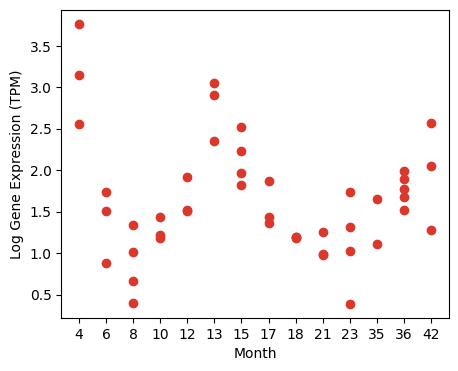

In [47]:
example_logexp = log_expression_subset_df.loc[SSdf.index[15], :].to_numpy()
fig1, ax1=plt.subplots(figsize=(5, 4))
ax1.scatter(xvals, example_logexp, color=color_red)
ax1.set_xticks(np.arange(len(unique_ages)), labels=unique_ages)
ax1.set_xlabel('Month')
ax1.set_ylabel('Log Gene Expression (TPM)')


Save the top 1000 genes.

In [48]:
SSdf.iloc[0:1000, :].to_csv("linear_model/topgenes.tsv", sep='\t')